# Testing some models

In [1]:
import pandas as pd
from taxipred.utils.constants import CLEANED_DATA

df = pd.read_csv(CLEANED_DATA / "taxi_prices_cleaned.csv")
df.head()

,trip_distance_km,time_of_day,day_of_week,traffic_conditions,weather,base_fare,per_km_rate,per_minute_rate,trip_duration_minutes,trip_price
0,19.35,Morning,Weekday,Low,Clear,3.56,0.80,0.32,53.82,36.2624
1,36.87,Evening,Weekend,High,Clear,2.70,1.21,0.15,37.27,52.9032
2,30.33,Evening,Weekday,Low,NaN,3.48,0.51,0.15,116.81,36.4698
3,8.64,Afternoon,Weekend,Medium,Clear,2.55,1.71,0.48,89.33,60.2028
4,3.85,Afternoon,Weekday,High,Rain,3.51,1.66,NaN,5.05,11.2645


### Separating features and target

In [2]:
X, y = df.drop(columns="trip_price"), df["trip_price"]
X.shape, y.shape

((833, 9), (833,))

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Defining numerical features vs. categorical features

In [4]:
num_feature = X_train.select_dtypes(include=["number"]).columns
cat_feature = X_train.select_dtypes(include=["object"]).columns

num_feature, cat_feature

(Index(['trip_distance_km', 'base_fare', 'per_km_rate', 'per_minute_rate',
        'trip_duration_minutes'],
       dtype='object'),
 Index(['time_of_day', 'day_of_week', 'traffic_conditions', 'weather'], dtype='object'))

#### Filling NaN with a "default/median" values for both cat and num features
 - Making sure I don't calculate median and mode from test, just train.
 - Applying to both train and test after assuing the calculations comes only from train (to avoid data leakage)

In [5]:
train_median = X_train[num_feature].median()
train_mode = X_train[cat_feature].mode().iloc[0]

X_train[num_feature] = X_train[num_feature].fillna(train_median)
X_test[num_feature] = X_test[num_feature].fillna(train_median)

X_train[cat_feature] = X_train[cat_feature].fillna(train_mode)
X_test[cat_feature] = X_test[cat_feature].fillna(train_mode)

### Get dummies for categorical features

In [6]:
X_train = pd.get_dummies(X_train, columns=cat_feature, drop_first=True)
X_test = pd.get_dummies(X_test, columns=cat_feature, drop_first=True)

X_train.shape, X_test.shape

((558, 13), (275, 13))

#### Aligning columns to make sure they are in same order

In [7]:
X_train, X_test = X_train.align(X_test, join="left", axis=1, fill_value=0)

X_train.columns, X_test.columns

(Index(['trip_distance_km', 'base_fare', 'per_km_rate', 'per_minute_rate',
        'trip_duration_minutes', 'time_of_day_Evening', 'time_of_day_Morning',
        'time_of_day_Night', 'day_of_week_Weekend', 'traffic_conditions_Low',
        'traffic_conditions_Medium', 'weather_Rain', 'weather_Snow'],
       dtype='object'),
 Index(['trip_distance_km', 'base_fare', 'per_km_rate', 'per_minute_rate',
        'trip_duration_minutes', 'time_of_day_Evening', 'time_of_day_Morning',
        'time_of_day_Night', 'day_of_week_Weekend', 'traffic_conditions_Low',
        'traffic_conditions_Medium', 'weather_Rain', 'weather_Snow'],
       dtype='object'))

## Scaling for LR and KNN

In [8]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

### Quick function to keep DRY

In [9]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

def eval_model(y_test, y_pred):
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    return {"MAE": mae, "RMSE": rmse}

def train_predict_eval(X_train, y_train, X_test, y_test, model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    eval = eval_model(y_test, y_pred)
    return eval

# Linear Regression

In [10]:
from sklearn.linear_model import LinearRegression

lr_model = LinearRegression()
lr_eval = train_predict_eval(scaled_X_train, y_train, scaled_X_test, y_test, lr_model)
lr_eval

{'MAE': 5.734756458835467, 'RMSE': np.float64(7.302333889700571)}

# KNN

Before i train KNN-model, I want to check best number of neighbours for this dataset.

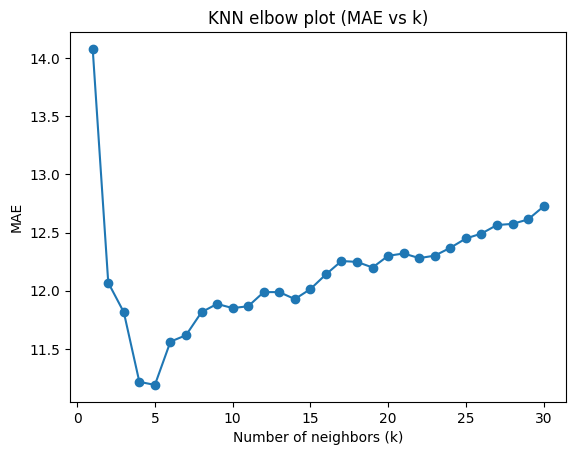

In [11]:
from sklearn.neighbors import KNeighborsRegressor
import matplotlib.pyplot as plt

k_values = range(1, 31)
mae_scores = []

for k in k_values:
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(scaled_X_train, y_train)
    y_pred = knn.predict(scaled_X_test)
    mae_scores.append(mean_absolute_error(y_test, y_pred))

plt.plot(k_values, mae_scores, marker="o")
plt.xlabel("Number of neighbors (k)")
plt.ylabel("MAE")
plt.title("KNN elbow plot (MAE vs k)")
plt.show()

#### Decision: 5 number of neighbours

In [12]:
knn_model = KNeighborsRegressor(n_neighbors=5)
knn_eval = train_predict_eval(scaled_X_train, y_train, scaled_X_test, y_test, knn_model)
knn_eval

{'MAE': 11.190583927272726, 'RMSE': np.float64(13.775029643787303)}

# Random Forest

In [13]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(random_state=42)
rf_eval = train_predict_eval(X_train, y_train, X_test, y_test, rf_model)
rf_eval

{'MAE': 4.513625407272727, 'RMSE': np.float64(6.2432395051652785)}

# Evaluation

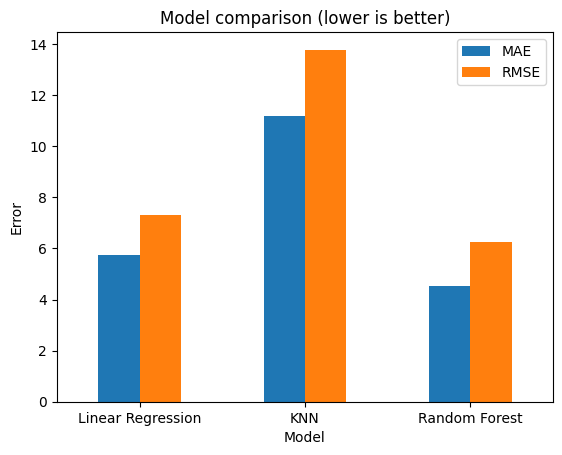

In [14]:
scores = pd.DataFrame({
    "Model": ["Linear Regression", "KNN", "Random Forest"],
    "MAE": [lr_eval["MAE"], knn_eval["MAE"], rf_eval["MAE"]],
    "RMSE": [lr_eval["RMSE"], knn_eval["RMSE"], rf_eval["RMSE"]],
})

scores.set_index("Model").plot(kind="bar")
plt.ylabel("Error")
plt.title("Model comparison (lower is better)")
plt.xticks(rotation=0)
plt.show()

## Conclusion:

- Random forest clearly outdoes the other models
- KNN is sensitive to noise and didn't leave any room for further tuning, so I discard it
- Linear Regression gives a stable baseline, but since Random forest performed better.. Random forest it is!